In [161]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

font_path ='/usr/share/fonts/opentype/noto/NotoSerifCJK-ExtraLight.ttc'
font_name = matplotlib.font_manager.FontProperties(fname=font_path).get_name()
matplotlib.rc("font", family = font_name)
from sklearn.tree import export_graphviz
import graphviz
import seaborn as sns #데이터 시각화(추세 등) 패키지
from sklearn.preprocessing import scale, minmax_scale, robust_scale #Scaling클래스
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV #최적모델,파라미터 탐색
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

# 1. 그래디언트 부스팅

콘크리트 강도를 예측하는 그래디언트 부스팅 모델을 만들고 predict method를 이용하여 예측값을 구하라. 그리고 모델의 mse와 mae를 산출하여 비교하라. 
데이터 : Concrete.CSV(변수: 9개, 자료 수: 1,030개)
 -.목표변수(Concrete_compressive_strength)

※ 데이터는 ( train(0.4) : validation(0.3) : test(0.3) )의 비율로 분할 (train_test_split 활용)
 0. train_test_split 함수를 이용하여 train:test로 데이터 분할. 분할된 train 데이터를 재 분할하여 validation 데이터로 사용
 1. train 데이터: 모델 훈련 
 2. validation 데이터: 최적의 parameter 찾기(과정의 [연습/실습]에서 test 데이터 역할)
 3. test 데이터: 2에서 찾은 최적의 parameter를 이용하여 만든 모델로 최종 성능 확인(단 한 번만 사용할 것)

In [2]:
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
df_raw = pd.read_csv("data/Concrete.csv", engine = "python", encoding = 'cp949')
df_raw.head()

,CEMENT,BLAST_FURNACE_SLAG,FLY_ASH,WATER,SUPERPLASTICIZER,COARSE_AGGREGATE,FINE_AGGREGATE,AGE,CONCRETE_COMPRESSIVE_STRENGTH
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [4]:
df_raw.shape

(1030, 9)

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CEMENT                         1030 non-null   float64
 1   BLAST_FURNACE_SLAG             1030 non-null   float64
 2   FLY_ASH                        1030 non-null   float64
 3   WATER                          1030 non-null   float64
 4   SUPERPLASTICIZER               1030 non-null   float64
 5   COARSE_AGGREGATE               1030 non-null   float64
 6   FINE_AGGREGATE                 1030 non-null   float64
 7   AGE                            1030 non-null   int64  
 8   CONCRETE_COMPRESSIVE_STRENGTH  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


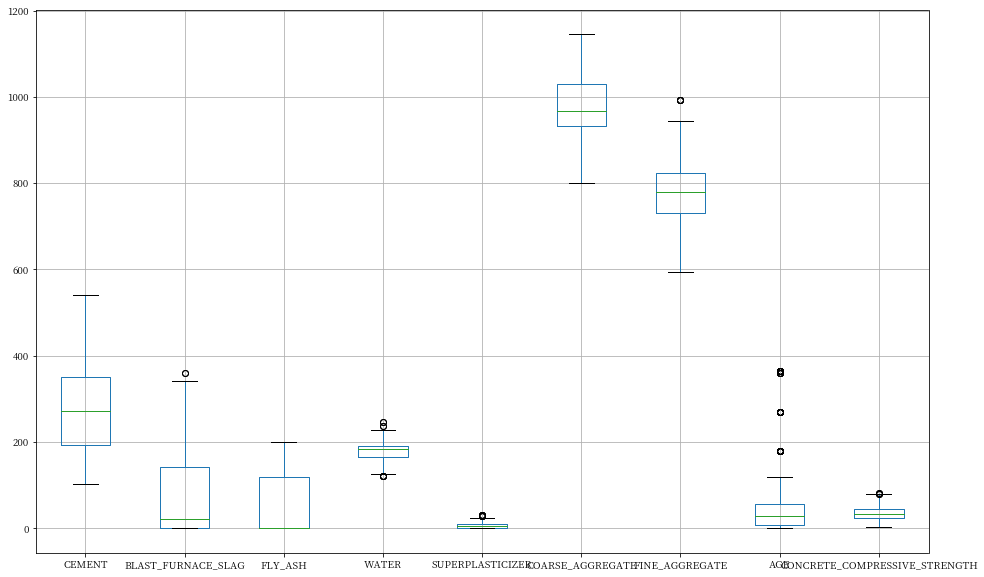

In [6]:
#이상치확인 
df_raw.boxplot(figsize=(16,10))

In [7]:
#AGE >=350 인 것은 이상치로 판단 
df_raw[df_raw['AGE']>=350]

,CEMENT,BLAST_FURNACE_SLAG,FLY_ASH,WATER,SUPERPLASTICIZER,COARSE_AGGREGATE,FINE_AGGREGATE,AGE,CONCRETE_COMPRESSIVE_STRENGTH
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,365,43.70
17,342.0,38.0,0.0,228.0,0.0,932.0,670.0,365,56.14
24,380.0,0.0,0.0,228.0,0.0,932.0,670.0,365,52.52
30,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,55.26
31,266.0,114.0,0.0,228.0,0.0,932.0,670.0,365,52.91
34,190.0,190.0,0.0,228.0,0.0,932.0,670.0,365,53.69
41,427.5,47.5,0.0,228.0,0.0,932.0,594.0,365,43.70
42,237.5,237.5,0.0,228.0,0.0,932.0,594.0,365,39.00


In [8]:
# 이상치 데이터 제거하고 나머지 df_raw로 저장하기 
df_raw = df_raw[df_raw['AGE']<350]
df_raw[['AGE']]

,AGE
0,28
1,28
2,270
5,90
7,28
...,...
1025,28
1026,28
1027,28
1028,28


In [9]:
df_raw['AGE'].count()

1010

In [10]:
# 데이터 분할 4:3:3
df_raw_y = df_raw["CONCRETE_COMPRESSIVE_STRENGTH"]
df_raw_x = df_raw.drop("CONCRETE_COMPRESSIVE_STRENGTH",axis = 1, inplace =False)

In [11]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x,df_raw_y,test_size = 3/10,random_state =1234)
df_train_x, df_val_x, df_train_y, df_val_y = train_test_split(df_train_x,df_train_y,test_size = 3/7,random_state =1234)

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("val data X size : {}".format(df_val_x.shape))
print("val data Y size : {}".format(df_val_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (404, 8)
train data Y size : (404,)
val data X size : (303, 8)
val data Y size : (303,)
test data X size : (303, 8)
test data Y size : (303,)


In [12]:
# GradientBoostingRegressor 모델생성
gb_uncustomized =GradientBoostingRegressor(random_state=1234)
gb_uncustomized.fit(df_train_x,df_train_y)
print("Score in training set : {:.3f}".format(gb_uncustomized.score(df_train_x,df_train_y)))
print("Score in val set : {:.3f}".format(gb_uncustomized.score(df_val_x,df_val_y)))

Score in training set : 0.952
Score in val set : 0.882


In [13]:
#train 및 val 설명력 결과 저장
train_score = []; val_score =[]

para_n_tree = [n_tree * 10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree :
    gb = GradientBoostingRegressor(random_state=1234,n_estimators =v_n_estimators)
    gb.fit(df_train_x,df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    val_score.append(gb.score(df_val_x, df_val_y))

    
df_score_n =pd.DataFrame()
df_score_n['Estimators']=para_n_tree
df_score_n['Train_Score']=train_score
df_score_n['Val_Score']=val_score

#모델의 설명력 표로 확인
df_score_n.round(3)  

,Estimators,Train_Score,Val_Score
0,10,0.645,0.595
1,20,0.811,0.754
2,30,0.875,0.814
3,40,0.903,0.842
4,50,0.918,0.854
5,60,0.929,0.863
6,70,0.937,0.870
7,80,0.943,0.875
8,90,0.948,0.878
9,100,0.952,0.882


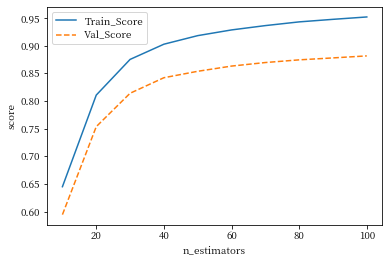

In [14]:
#모델의 설명력 그래프로 확인
plt.plot(para_n_tree,train_score,linestyle = "-", label = "Train_Score")
plt.plot(para_n_tree,val_score,linestyle = "--", label = "Val_Score")
plt.ylabel("score");plt.xlabel("n_estimators")
plt.legend()

n_estimators = 30으로 지정   
(그래프에서 Trainscore와 valscore 차이가 작으면서도 score값이 0.8이상이므로 가장 적합하다고 판단했음)

In [15]:
#min_samples_leaf 결정을 위해
train_score = []; val_score =[]
para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf :
    rf = GradientBoostingRegressor(random_state=1234,n_estimators =30,min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    val_score.append(rf.score(df_val_x, df_val_y))

    
df_score_leaf =pd.DataFrame()
df_score_leaf['MinSampleLeaf']=para_leaf
df_score_leaf['Train_Score']=train_score
df_score_leaf['Val_Score']=val_score

df_score_leaf.round(3)

,MinSampleLeaf,Train_Score,Val_Score
0,1,0.875,0.814
1,2,0.875,0.814
2,3,0.876,0.816
3,4,0.875,0.812
4,5,0.875,0.812
5,6,0.874,0.816
6,7,0.873,0.811
7,8,0.873,0.811
8,9,0.874,0.814
9,10,0.873,0.817


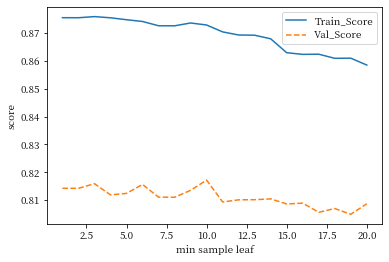

In [16]:
plt.plot(para_leaf,train_score,linestyle = "-", label = "Train_Score")
plt.plot(para_leaf,val_score,linestyle = "--", label = "Val_Score")
plt.ylabel("score");plt.xlabel("min sample leaf")
plt.legend()

min_samples_leaf = 10 으로 지정

In [17]:
# min_samples_split 결정을 위해 
train_score = []; val_score =[]
para_split = [n_split * 2 for n_split in range(1,21)]

for v_min_samples_split in para_split :
    gb = GradientBoostingRegressor(random_state=1234,n_estimators =30,min_samples_leaf=10,min_samples_split=v_min_samples_split)
    gb.fit(df_train_x,df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    val_score.append(gb.score(df_val_x, df_val_y))

    
df_score_split =pd.DataFrame()
df_score_split['MinSampleSplit']=para_split
df_score_split['TrainScore']=train_score
df_score_split['ValScore']=val_score

df_score_split.round(3)

,MinSampleSplit,TrainScore,ValScore
0,2,0.873,0.817
1,4,0.873,0.817
2,6,0.873,0.817
3,8,0.873,0.817
4,10,0.873,0.817
5,12,0.873,0.817
6,14,0.873,0.817
7,16,0.873,0.817
8,18,0.873,0.817
9,20,0.873,0.817


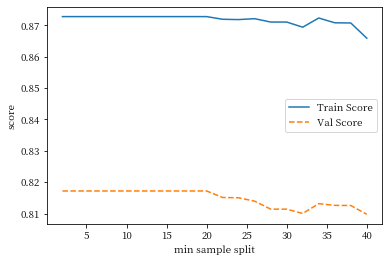

In [18]:
plt.plot(para_split,train_score,linestyle = "-", label = "Train Score")
plt.plot(para_split,val_score,linestyle = "--", label = "Val Score")
plt.ylabel("score");plt.xlabel("min sample split")
plt.legend()

min_samples_split = 32 로 지정 

In [19]:
# max_depth 결정을 위해 

train_score = []; val_score =[]
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth :
    gb = GradientBoostingRegressor(random_state=1234,n_estimators =30,min_samples_leaf=10,min_samples_split=32,max_depth=v_max_depth)
    gb.fit(df_train_x,df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    val_score.append(gb.score(df_val_x, df_val_y))

    
df_score_depth =pd.DataFrame()
df_score_depth['Depth']=para_depth
df_score_depth['TrainScore']=train_score
df_score_depth['ValScore']=val_score

df_score_depth.round(3)

,Depth,TrainScore,ValScore
0,1,0.584,0.568
1,2,0.789,0.757
2,3,0.869,0.810
3,4,0.906,0.849
4,5,0.926,0.860
5,6,0.936,0.864
6,7,0.938,0.864
7,8,0.944,0.871
8,9,0.944,0.871
9,10,0.944,0.870


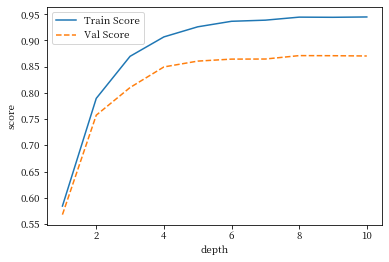

In [20]:
plt.plot(para_depth,train_score,linestyle = "-", label = "Train Score")
plt.plot(para_depth,val_score,linestyle = "--", label = "Val Score")
plt.ylabel("score");plt.xlabel("depth")
plt.legend()

max_depth = 4 로 지정 

In [21]:
# learning_rate 결정을 위해 
train_score = []; val_score =[]
para_lr = [lr * 0.1 for lr in range(1,10)]

for v_learning_rate in para_lr :
    gb = GradientBoostingRegressor(random_state=1234, n_estimators =30\
                                   ,min_samples_leaf=10,min_samples_split=32\
                                   ,max_depth=4, learning_rate = v_learning_rate)
    gb.fit(df_train_x,df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    val_score.append(gb.score(df_val_x, df_val_y))

    
df_score_lr =pd.DataFrame()
df_score_lr['LearningRate']=para_lr
df_score_lr['TrainScore']=train_score
df_score_lr['ValScore']=val_score

df_score_lr.round(3)

,LearningRate,TrainScore,ValScore
0,0.1,0.906,0.849
1,0.2,0.944,0.880
2,0.3,0.959,0.893
3,0.4,0.967,0.890
4,0.5,0.970,0.879
5,0.6,0.969,0.877
6,0.7,0.970,0.868
7,0.8,0.974,0.866
8,0.9,0.978,0.865


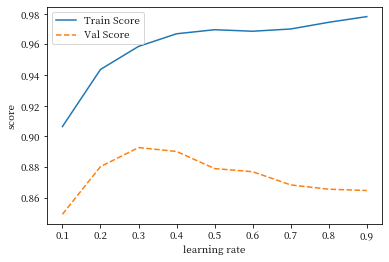

In [22]:
plt.plot(para_lr,train_score,linestyle = "-", label = "Train Score")
plt.plot(para_lr,val_score,linestyle = "--", label = "Val Score")
plt.ylabel("score");plt.xlabel("learning rate")
plt.legend()

learning_rate = 0.3 으로 지정

In [23]:
# 최종모델생성
gb_final = GradientBoostingRegressor(random_state=1234,n_estimators=30\
                                     ,min_samples_leaf=10,min_samples_split=32\
                                     ,max_depth=4,learning_rate=0.3)
gb_final.fit(df_train_x,df_train_y)

print("Score on training set : {:.3f}".format(gb_final.score(df_train_x,df_train_y)))
print("Score on test set : {:.3f}".format(gb_final.score(df_test_x,df_test_y)))

Score on training set : 0.959
Score on test set : 0.909


In [24]:
# 변수명 저장 
v_feature_name = df_train_x.columns

# 설명변수의 중요도 
df_importance = pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"]=gb_final.feature_importances_

df_importance.sort_values("Importance",ascending = False, inplace =True)
df_importance.round(3)

,Feature,Importance
7,AGE,0.358
0,CEMENT,0.311
3,WATER,0.136
1,BLAST_FURNACE_SLAG,0.074
4,SUPERPLASTICIZER,0.059
6,FINE_AGGREGATE,0.041
5,COARSE_AGGREGATE,0.013
2,FLY_ASH,0.009


Text(0, 0.5, '변수')

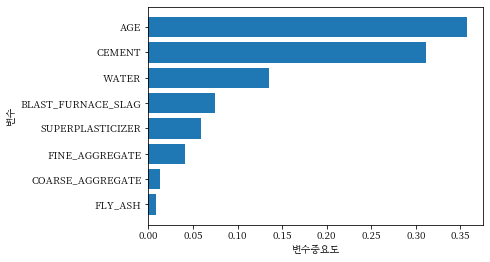

In [25]:
df_importance.sort_values("Importance",ascending=True,inplace = True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width=df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수중요도")
plt.ylabel("변수")

※ 결론 : 콘크리트 압축강도는 AGE, CEMENT, WATER 순으로 영향을 받는다고 해석할 수 있다. 

In [ ]:
# estimator = GradientBoostingRegressor(random_state=1234)
# param_grid = {"criterion":["mse","friedman_mse","mae"]\
#               ,"max_features":["auto","sqrt","log2"],"learning_rate":para_lr\
#               ,"max_depth":para_depth,"min_samples_leaf":para_leaf}

# grid_gb = GridSearchCV(estimator,param_grid,scoring="r2",n_jobs = -1)
# grid_gb.fit(df_train_x,df_train_y)

# print("best estimator model:\n{}".format(grid_gb.best_estimator_))
# print("\nbest parameter:\n{}".format(grid_gb.best_params_))
# print("\nbestscore:\n{}".format(grid_gb.best_score_round(3)))

# 2. 주성분분석

데이터 표준화 이후, 주성분 분석을 실시하여 2차원(1 vs 2 주성분, 1 vs 3 주성분, …) 산점도를 그려라.  
(목표변수로 색 구분), + 주성분 naming  

데이터 : 유방암.CSV(변수: 31개, 자료 수: 569개)
목표변수(diagnosis, 0: Malignant(악성,357개), 1: Benign(양성,212개

In [162]:
df_raw = pd.read_csv("data/유방암.csv",engine="python",encoding = 'cp949')
df_raw.head()

,diagnosis,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [163]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   mean radius              569 non-null    float64
 2   mean texture             569 non-null    float64
 3   mean perimeter           569 non-null    float64
 4   mean area                569 non-null    float64
 5   mean smoothness          569 non-null    float64
 6   mean compactness         569 non-null    float64
 7   mean concavity           569 non-null    float64
 8   mean concave points      569 non-null    float64
 9   mean symmetry            569 non-null    float64
 10  mean fractal dimension   569 non-null    float64
 11  radius error             569 non-null    float64
 12  texture error            569 non-null    float64
 13  perimeter error          569 non-null    float64
 14  area error               5

In [164]:
# 데이터분리 -> 목표변수 :diagnosis , 설명변수 :diagnosis 제외한 나머지  
df_raw_x = df_raw.drop("diagnosis",axis=1)
df_raw_y = df_raw["diagnosis"]
df_raw_y.head()
df_raw_x.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [165]:
# x변수간의 상관성이 있는지 확인하기 
df_raw_x.corr().round(3)  

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
mean radius,1.000,0.324,0.998,0.987,0.171,0.506,0.677,0.823,0.148,-0.312,...,0.970,0.297,0.965,0.941,0.120,0.413,0.527,0.744,0.164,0.007
mean texture,0.324,1.000,0.330,0.321,-0.023,0.237,0.302,0.293,0.071,-0.076,...,0.353,0.912,0.358,0.344,0.078,0.278,0.301,0.295,0.105,0.119
mean perimeter,0.998,0.330,1.000,0.987,0.207,0.557,0.716,0.851,0.183,-0.261,...,0.969,0.303,0.970,0.942,0.151,0.456,0.564,0.771,0.189,0.051
mean area,0.987,0.321,0.987,1.000,0.177,0.499,0.686,0.823,0.151,-0.283,...,0.963,0.287,0.959,0.959,0.124,0.390,0.513,0.722,0.144,0.004
mean smoothness,0.171,-0.023,0.207,0.177,1.000,0.659,0.522,0.554,0.558,0.585,...,0.213,0.036,0.239,0.207,0.805,0.472,0.435,0.503,0.394,0.499
mean compactness,0.506,0.237,0.557,0.499,0.659,1.000,0.883,0.831,0.603,0.565,...,0.535,0.248,0.590,0.510,0.566,0.866,0.816,0.816,0.510,0.687
mean concavity,0.677,0.302,0.716,0.686,0.522,0.883,1.000,0.921,0.501,0.337,...,0.688,0.300,0.730,0.676,0.449,0.755,0.884,0.861,0.409,0.515
mean concave points,0.823,0.293,0.851,0.823,0.554,0.831,0.921,1.000,0.462,0.167,...,0.830,0.293,0.856,0.810,0.453,0.667,0.752,0.910,0.376,0.369
mean symmetry,0.148,0.071,0.183,0.151,0.558,0.603,0.501,0.462,1.000,0.480,...,0.186,0.091,0.219,0.177,0.427,0.473,0.434,0.430,0.700,0.438
mean fractal dimension,-0.312,-0.076,-0.261,-0.283,0.585,0.565,0.337,0.167,0.480,1.000,...,-0.254,-0.051,-0.205,-0.232,0.505,0.459,0.346,0.175,0.334,0.767


In [166]:
#요약통계량 -> scale변환 필요 확인
df_raw_x.describe().round(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,...,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000
mean,14.127,19.290,91.969,654.889,0.096,0.104,0.089,0.049,0.181,0.063,...,16.269,25.677,107.261,880.583,0.132,0.254,0.272,0.115,0.290,0.084
std,3.524,4.301,24.299,351.914,0.014,0.053,0.080,0.039,0.027,0.007,...,4.833,6.146,33.603,569.357,0.023,0.157,0.209,0.066,0.062,0.018
min,6.981,9.710,43.790,143.500,0.053,0.019,0.000,0.000,0.106,0.050,...,7.930,12.020,50.410,185.200,0.071,0.027,0.000,0.000,0.156,0.055
25%,11.700,16.170,75.170,420.300,0.086,0.065,0.030,0.020,0.162,0.058,...,13.010,21.080,84.110,515.300,0.117,0.147,0.114,0.065,0.250,0.071
50%,13.370,18.840,86.240,551.100,0.096,0.093,0.062,0.034,0.179,0.062,...,14.970,25.410,97.660,686.500,0.131,0.212,0.227,0.100,0.282,0.080
75%,15.780,21.800,104.100,782.700,0.105,0.130,0.131,0.074,0.196,0.066,...,18.790,29.720,125.400,1084.000,0.146,0.339,0.383,0.161,0.318,0.092
max,28.110,39.280,188.500,2501.000,0.163,0.345,0.427,0.201,0.304,0.097,...,36.040,49.540,251.200,4254.000,0.223,1.058,1.252,0.291,0.664,0.208


In [167]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [168]:
#변수이름저장
x_cols = df_raw_x.columns

#scale 변환 :ndarray 형식
# 데이터의 값의 단위 or '크기에 따라서 데이터가 분산량이 왜곡될 수 있기 때문에 표준화를 진행 
scaler = StandardScaler()
nd_scaled = scaler.fit_transform(df_raw_x)

#변환된 데이터 및 형태확인
print("Scaled Data : \n{}".format(nd_scaled[:5].round(3)))
print("Shape : \n{}".format(nd_scaled.shape))

Scaled Data : 
[[ 1.097e+00 -2.073e+00  1.270e+00  9.840e-01  1.568e+00  3.284e+00
   2.653e+00  2.532e+00  2.218e+00  2.256e+00  2.490e+00 -5.650e-01
   2.833e+00  2.488e+00 -2.140e-01  1.317e+00  7.240e-01  6.610e-01
   1.149e+00  9.070e-01  1.887e+00 -1.359e+00  2.304e+00  2.001e+00
   1.308e+00  2.617e+00  2.110e+00  2.296e+00  2.751e+00  1.937e+00]
 [ 1.830e+00 -3.540e-01  1.686e+00  1.909e+00 -8.270e-01 -4.870e-01
  -2.400e-02  5.480e-01  1.000e-03 -8.690e-01  4.990e-01 -8.760e-01
   2.630e-01  7.420e-01 -6.050e-01 -6.930e-01 -4.410e-01  2.600e-01
  -8.050e-01 -9.900e-02  1.806e+00 -3.690e-01  1.535e+00  1.890e+00
  -3.760e-01 -4.300e-01 -1.470e-01  1.087e+00 -2.440e-01  2.810e-01]
 [ 1.580e+00  4.560e-01  1.567e+00  1.559e+00  9.420e-01  1.053e+00
   1.363e+00  2.037e+00  9.400e-01 -3.980e-01  1.229e+00 -7.800e-01
   8.510e-01  1.181e+00 -2.970e-01  8.150e-01  2.130e-01  1.425e+00
   2.370e-01  2.940e-01  1.512e+00 -2.400e-02  1.347e+00  1.456e+00
   5.270e-01  1.083e+00  8.550e

In [169]:
# 표준화된 데이터로 주성분분석을 진행
df_scaled = pd.DataFrame(nd_scaled,columns = x_cols)
df_scaled.head().round(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1.097,-2.073,1.270,0.984,1.568,3.284,2.653,2.532,2.218,2.256,...,1.887,-1.359,2.304,2.001,1.308,2.617,2.110,2.296,2.751,1.937
1,1.830,-0.354,1.686,1.909,-0.827,-0.487,-0.024,0.548,0.001,-0.869,...,1.806,-0.369,1.535,1.890,-0.376,-0.430,-0.147,1.087,-0.244,0.281
2,1.580,0.456,1.567,1.559,0.942,1.053,1.363,2.037,0.940,-0.398,...,1.512,-0.024,1.347,1.456,0.527,1.083,0.855,1.955,1.152,0.201
3,-0.769,0.254,-0.593,-0.764,3.284,3.403,1.916,1.452,2.867,4.911,...,-0.281,0.134,-0.250,-0.550,3.394,3.893,1.990,2.176,6.046,4.935
4,1.750,-1.152,1.777,1.826,0.280,0.539,1.371,1.428,-0.010,-0.562,...,1.299,-1.467,1.339,1.221,0.221,-0.313,0.613,0.729,-0.868,-0.397


In [170]:
df_scaled.describe().round(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,...,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000
mean,-0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,...,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000
std,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,...,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001
min,-2.030,-2.229,-1.985,-1.454,-3.112,-1.610,-1.115,-1.262,-2.744,-1.820,...,-1.727,-2.224,-1.693,-1.222,-2.683,-1.444,-1.306,-1.745,-2.161,-1.602
25%,-0.689,-0.726,-0.692,-0.667,-0.711,-0.747,-0.744,-0.738,-0.703,-0.723,...,-0.675,-0.749,-0.690,-0.642,-0.691,-0.681,-0.757,-0.756,-0.642,-0.692
50%,-0.215,-0.105,-0.236,-0.295,-0.035,-0.222,-0.342,-0.398,-0.072,-0.178,...,-0.269,-0.044,-0.286,-0.341,-0.047,-0.270,-0.218,-0.223,-0.127,-0.216
75%,0.469,0.584,0.500,0.364,0.636,0.494,0.526,0.647,0.531,0.471,...,0.522,0.658,0.540,0.358,0.598,0.540,0.531,0.713,0.450,0.451
max,3.971,4.652,3.976,5.251,4.771,4.568,4.244,3.928,4.485,4.911,...,4.094,3.886,4.287,5.930,3.955,5.113,4.701,2.686,6.046,6.847


In [171]:
from sklearn.decomposition import PCA

In [172]:
df_raw

,diagnosis,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [181]:
# 주성분분석 
pca = PCA(n_components = 30)
nd_pca=pca.fit_transform(df_scaled)

#생성된 주성분 점수확인
print("PCA Data:\n{}".format(nd_pca[:5]))
print("Shape : \n{}".format(nd_pca.shape))

PCA Data:
[[ 9.19283683e+00  1.94858307e+00 -1.12316616e+00  3.63373090e+00
  -1.19511012e+00  1.41142445e+00  2.15936987e+00 -3.98407230e-01
  -1.57118359e-01 -8.77401880e-01  2.62955455e-01 -8.59014477e-01
   1.03387665e-01 -6.90804097e-01 -6.01793127e-01  7.45115792e-01
  -2.65470777e-01 -5.49562693e-01 -1.33767500e-01  3.45564905e-01
   9.65148929e-02  6.88499220e-02  8.45185932e-02 -1.75256284e-01
  -1.51020059e-01 -2.01503451e-01 -2.52584993e-01 -3.39144536e-02
   4.56477199e-02 -4.71692081e-02]
 [ 2.38780180e+00 -3.76817174e+00 -5.29292687e-01  1.11826386e+00
   6.21774980e-01  2.86563545e-02  1.33580935e-02  2.40988459e-01
  -7.11904816e-01  1.10699494e+00  8.13119658e-01  1.57922585e-01
  -9.43529283e-01 -6.53475327e-01  8.97486713e-03 -6.48808694e-01
  -1.72122035e-02  3.18297381e-01  2.47564629e-01 -1.14133080e-01
  -7.73274741e-02 -9.45784509e-02 -2.17718064e-01  1.12901180e-02
  -1.70510254e-01 -4.11287846e-02  1.81270166e-01  3.26241827e-02
  -5.68742432e-03 -1.86787626e-

In [182]:
nd_pca.shape

(569, 30)

In [183]:
df_pca = pd.DataFrame(nd_pca\
                      ,columns=["Prin"+str(i) for i in range(1,31)])
df_scaled_pca = df_scaled.join(df_pca)
df_scaled_pca.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,Prin21,Prin22,Prin23,Prin24,Prin25,Prin26,Prin27,Prin28,Prin29,Prin30
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,0.096515,0.068850,0.084519,-0.175256,-0.151020,-0.201503,-0.252585,-0.033914,0.045648,-0.047169
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,-0.077327,-0.094578,-0.217718,0.011290,-0.170510,-0.041129,0.181270,0.032624,-0.005687,-0.001868
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,0.311067,-0.060309,-0.074291,0.102762,0.171158,0.004735,0.049569,0.047026,0.003146,0.000751
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,0.434193,-0.203266,-0.124105,0.153430,0.077496,-0.275225,0.183462,0.042484,-0.069295,-0.019937
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,-0.116545,-0.017650,0.139454,-0.005332,0.003062,0.039254,0.032168,-0.034786,0.005038,0.021214


In [184]:
df_scaled

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,2.110995,0.721473,2.060786,2.343856,1.041842,0.219060,1.947285,2.320965,-0.312589,-0.931027,...,1.901185,0.117700,1.752563,2.015301,0.378365,-0.273318,0.664512,1.629151,-1.360158,-0.709091
565,1.704854,2.085134,1.615931,1.723842,0.102458,-0.017833,0.693043,1.263669,-0.217664,-1.058611,...,1.536720,2.047399,1.421940,1.494959,-0.691230,-0.394820,0.236573,0.733827,-0.531855,-0.973978
566,0.702284,2.045574,0.672676,0.577953,-0.840484,-0.038680,0.046588,0.105777,-0.809117,-0.895587,...,0.561361,1.374854,0.579001,0.427906,-0.809587,0.350735,0.326767,0.414069,-1.104549,-0.318409
567,1.838341,2.336457,1.982524,1.735218,1.525767,3.272144,3.296944,2.658866,2.137194,1.043695,...,1.961239,2.237926,2.303601,1.653171,1.430427,3.904848,3.197605,2.289985,1.919083,2.219635


In [185]:
df_pca

,Prin1,Prin2,Prin3,Prin4,Prin5,Prin6,Prin7,Prin8,Prin9,Prin10,...,Prin21,Prin22,Prin23,Prin24,Prin25,Prin26,Prin27,Prin28,Prin29,Prin30
0,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159370,-0.398407,-0.157118,-0.877402,...,0.096515,0.068850,0.084519,-0.175256,-0.151020,-0.201503,-0.252585,-0.033914,0.045648,-0.047169
1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013358,0.240988,-0.711905,1.106995,...,-0.077327,-0.094578,-0.217718,0.011290,-0.170510,-0.041129,0.181270,0.032624,-0.005687,-0.001868
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166,0.097374,0.024066,0.454275,...,0.311067,-0.060309,-0.074291,0.102762,0.171158,0.004735,0.049569,0.047026,0.003146,0.000751
3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,1.429911,1.059565,-1.405440,-1.116975,...,0.434193,-0.203266,-0.124105,0.153430,0.077496,-0.275225,0.183462,0.042484,-0.069295,-0.019937
4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,-0.936213,0.636376,-0.263805,0.377704,...,-0.116545,-0.017650,0.139454,-0.005332,0.003062,0.039254,0.032168,-0.034786,0.005038,0.021214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,6.439315,-3.576817,2.459487,1.177314,-0.074824,-2.375193,-0.596130,-0.035471,0.987929,0.256989,...,0.006888,-0.067000,0.088590,0.107898,0.219520,-0.122900,0.159198,0.009853,0.007119,-0.001415
565,3.793382,-3.584048,2.088476,-2.506028,-0.510723,-0.246710,-0.716326,-1.113360,-0.105207,-0.108632,...,-0.009802,0.019563,-0.055405,0.086135,0.001197,0.065889,-0.068512,-0.023575,-0.027486,-0.010419
566,1.256179,-1.902297,0.562731,-2.089227,1.809991,-0.534447,-0.192758,0.341887,0.393917,0.520877,...,-0.036592,0.063352,-0.200312,-0.044819,0.002429,0.007095,-0.023691,-0.002578,0.006706,0.003770
567,10.374794,1.672010,-1.877029,-2.356031,-0.033742,0.567936,0.223082,-0.280239,-0.542035,-0.089296,...,0.140648,-0.042478,0.168820,-0.195969,0.377830,-0.198192,-0.027409,-0.068086,-0.084163,-0.023783


In [186]:
# 주성분분석 및 결과 : 고유값확인 및 주성분 개수 결정 
df_pca_stat = pd.DataFrame()
df_pca_stat["PrinNo"] = [i for i in range(1,31)]
df_pca_stat["EigenValues"] = pca.explained_variance_
df_pca_stat["EigenValueRatio"] = pca.explained_variance_ratio_
df_pca_stat["CumEigenValueRatio"] = np.cumsum(pca.explained_variance_ratio_)
df_pca_stat.round(3)

,PrinNo,EigenValues,EigenValueRatio,CumEigenValueRatio
0,1,13.305,0.443,0.443
1,2,5.701,0.190,0.632
2,3,2.823,0.094,0.726
3,4,1.984,0.066,0.792
4,5,1.652,0.055,0.847
5,6,1.209,0.040,0.888
6,7,0.676,0.023,0.910
7,8,0.477,0.016,0.926
8,9,0.418,0.014,0.940
9,10,0.351,0.012,0.952


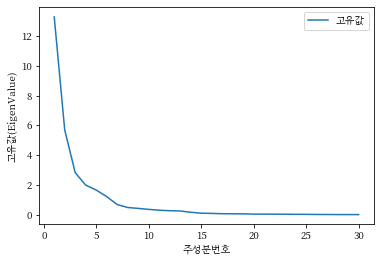

In [187]:
#screen plot
plt.plot(df_pca_stat["PrinNo"],df_pca_stat["EigenValues"],label="고유값")

plt.ylabel("고유값(EigenValue)")
plt.xlabel("주성분번호")
plt.legend(loc = "best")

※ 적정 주성분선택  
공분산기준(누적고유값비율 > 0.8 이기 시작한 지점) : 5개  

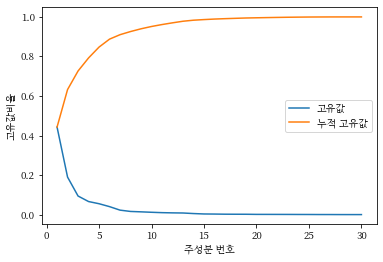

In [188]:
#고유값 비율 그래프 생성

plt.plot(df_pca_stat["PrinNo"],df_pca_stat["EigenValueRatio"],label="고유값")

plt.plot(df_pca_stat["PrinNo"],df_pca_stat["CumEigenValueRatio"],label="누적 고유값")

plt.ylabel("고유값비율")
plt.xlabel("주성분 번호")
plt.legend(loc = "best")

※ 적정 주성분선택   
그래프로 보아도 주성분번호 4인지점(5번쨰)에서 고유값비율이 0.8에 가까운 것을 볼수 있다.  

In [189]:
#주성분 분석 데이터의 변수 이름
x_cols = pd.DataFrame({"Feature":df_raw_x.columns})
df_eigenvector = pd.concat([x_cols\n
                            , pd.DataFrame(pca.components_.T * -1,\
                                               columns = ["Prin"+str(i) for i in range(1,31)])],axis =1)
df_eigenvector.round(3)

,Feature,Prin1,Prin2,Prin3,Prin4,Prin5,Prin6,Prin7,Prin8,Prin9,...,Prin21,Prin22,Prin23,Prin24,Prin25,Prin26,Prin27,Prin28,Prin29,Prin30
0,mean radius,-0.219,0.234,0.009,-0.041,-0.038,-0.019,0.124,0.007,0.223,...,0.069,-0.073,0.099,-0.183,-0.019,0.129,0.132,-0.211,-0.211,0.702
1,mean texture,-0.104,0.060,-0.065,0.603,0.049,0.032,-0.011,-0.131,-0.113,...,-0.448,-0.095,0.001,0.099,0.085,0.025,0.017,0.000,0.011,0.000
2,mean perimeter,-0.228,0.215,0.009,-0.042,-0.037,-0.017,0.114,0.019,0.224,...,0.070,-0.075,0.040,-0.117,0.027,0.125,0.115,-0.084,-0.384,-0.690
3,mean area,-0.221,0.231,-0.029,-0.053,-0.010,0.002,0.052,-0.035,0.196,...,0.018,-0.098,-0.008,0.070,-0.210,-0.363,-0.467,0.273,0.423,-0.033
4,mean smoothness,-0.143,-0.186,0.104,-0.159,0.365,0.286,0.141,0.289,-0.006,...,0.119,-0.064,0.021,0.069,0.029,0.037,-0.070,-0.001,0.003,-0.005
5,mean compactness,-0.239,-0.152,0.074,-0.032,-0.012,0.014,-0.031,0.151,0.168,...,-0.193,0.098,-0.052,-0.104,0.397,-0.263,-0.098,0.005,0.041,0.045
6,mean concavity,-0.258,-0.060,-0.003,-0.019,-0.086,0.009,0.108,0.073,-0.041,...,-0.006,0.185,-0.325,0.045,-0.097,0.549,-0.365,-0.046,0.010,0.025
7,mean concave points,-0.261,0.035,0.026,-0.065,0.044,0.052,0.150,0.152,0.112,...,0.009,0.312,0.051,0.084,-0.186,-0.388,0.455,0.009,0.004,-0.001
8,mean symmetry,-0.138,-0.190,0.040,-0.067,0.306,-0.356,0.094,0.232,-0.256,...,0.087,0.018,0.051,0.019,-0.025,0.016,0.015,-0.001,0.008,-0.001
9,mean fractal dimension,-0.064,-0.367,0.023,-0.049,0.044,0.119,-0.296,0.177,0.124,...,0.076,-0.288,0.085,-0.133,-0.207,0.097,0.101,0.006,-0.007,-0.005


In [190]:
df_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Prin1   569 non-null    float64
 1   Prin2   569 non-null    float64
 2   Prin3   569 non-null    float64
 3   Prin4   569 non-null    float64
 4   Prin5   569 non-null    float64
 5   Prin6   569 non-null    float64
 6   Prin7   569 non-null    float64
 7   Prin8   569 non-null    float64
 8   Prin9   569 non-null    float64
 9   Prin10  569 non-null    float64
 10  Prin11  569 non-null    float64
 11  Prin12  569 non-null    float64
 12  Prin13  569 non-null    float64
 13  Prin14  569 non-null    float64
 14  Prin15  569 non-null    float64
 15  Prin16  569 non-null    float64
 16  Prin17  569 non-null    float64
 17  Prin18  569 non-null    float64
 18  Prin19  569 non-null    float64
 19  Prin20  569 non-null    float64
 20  Prin21  569 non-null    float64
 21  Prin22  569 non-null    float64
 22  Pr

In [198]:
#df_pca.corr().round(3)  #주성분끼리는 서로 독립적인 것을 볼수있음

In [192]:
# 원천 데이터를 활용한 다중선형 회귀분석
df_raw_x_const = sm.add_constant(df_raw_x)
reg_model = sm.OLS(df_raw_y, df_raw_x_const)

reg_model = reg_model.fit()

print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:              diagnosis   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     61.53
Date:                Thu, 19 Nov 2020   Prob (F-statistic):          6.05e-153
Time:                        03:20:25   Log-Likelihood:                 29.650
No. Observations:                 569   AIC:                             2.699
Df Residuals:                     538   BIC:                             137.4
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [204]:
# scale변환 데이터 활용한 다중선형 회귀분석
df_scaled_const = sm.add_constant(df_scaled)

reg_model = sm.OLS(df_raw_y, df_scaled_const)
reg_model = reg_model.fit()

print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:              diagnosis   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     61.53
Date:                Thu, 19 Nov 2020   Prob (F-statistic):          6.05e-153
Time:                        03:33:42   Log-Likelihood:                 29.650
No. Observations:                 569   AIC:                             2.699
Df Residuals:                     538   BIC:                             137.4
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

원천 데이터를 활용한 다중선형 회귀분석과 scale변환 데이터 활용한 다중선형 회귀분석은 pvalue값과 R - squard는 변함없다.

In [205]:
# 다중선형 주성분 회귀분석 : 주성분 점수(score)데이터 활용 
x_var = ["Prin1","Prin2","Prin3"]

#선택된 주성분 점수 데이터에 절편(const)컬럼 추가 
df_pca_const = sm.add_constant(df_pca[x_var])

reg_model = sm.OLS(df_raw_y,df_pca_const)
reg_model = reg_model.fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:              diagnosis   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     399.5
Date:                Thu, 19 Nov 2020   Prob (F-statistic):          3.48e-139
Time:                        03:33:47   Log-Likelihood:                -70.033
No. Observations:                 569   AIC:                             148.1
Df Residuals:                     565   BIC:                             165.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3726      0.012     32.362      0.0

In [206]:
x_var = ["Prin1","Prin2"]

df_pca_const = sm.add_constant(df_pca[x_var])

reg_model = sm.OLS(df_raw_y,df_pca_const)
reg_model = reg_model.fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:              diagnosis   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     531.3
Date:                Thu, 19 Nov 2020   Prob (F-statistic):          1.25e-130
Time:                        03:36:37   Log-Likelihood:                -93.178
No. Observations:                 569   AIC:                             192.4
Df Residuals:                     566   BIC:                             205.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3726      0.012     31.099      0.0

3차원 회귀모델(adjusted R-squared = 0.678)과 2차원 회귀모델(adjusted R-squared = 0.651)은 설명력이 조금 줄긴 했지만, 차원을 3-> 2차원으로 축소하였기에 2차원 회귀모델로 생성하는 것이 더 나은 모델이라 생각한다.  

## Prin1, Prin2, diagnosis 로 2차원 산점도 그리기

In [210]:
df_pca_num = pd.DataFrame(nd_pca\
                      ,columns=["Prin"+str(i) for i in range(1,31)])

#diagnosis가 포함된 df_raw 데이터와 Prin1,2가 포함된 df_pca_num 을 join으로 결합시킴
df_raw_num = df_raw.join(df_pca_num)
df_raw_num.head()

,diagnosis,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,Prin21,Prin22,Prin23,Prin24,Prin25,Prin26,Prin27,Prin28,Prin29,Prin30
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,0.096515,0.068850,0.084519,-0.175256,-0.151020,-0.201503,-0.252585,-0.033914,0.045648,-0.047169
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,-0.077327,-0.094578,-0.217718,0.011290,-0.170510,-0.041129,0.181270,0.032624,-0.005687,-0.001868
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,0.311067,-0.060309,-0.074291,0.102762,0.171158,0.004735,0.049569,0.047026,0.003146,0.000751
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,0.434193,-0.203266,-0.124105,0.153430,0.077496,-0.275225,0.183462,0.042484,-0.069295,-0.019937
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,-0.116545,-0.017650,0.139454,-0.005332,0.003062,0.039254,0.032168,-0.034786,0.005038,0.021214


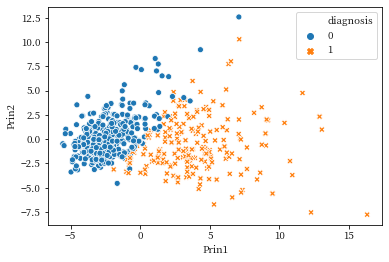

In [212]:
# df_raw_num 데이터를 이용하여 Prin1, Prin2, diagnosis 로 2차원 산점도 그리기 
sns.scatterplot(x = "Prin1", y = "Prin2",hue="diagnosis"\
                , style="diagnosis", data = df_raw_num)